In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

In [47]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

In [48]:
df_train.head(5)

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [49]:
def information(df):    
    print("##################### Shape #####################")
    print(df.shape)
    print("##################### Types #####################")    
    print(df.dtypes)
    print("##################### Columns #####################")
    print(df.columns)
    print("##################### Null #####################")
    print(df.isnull().sum())   
    print("##################### Describe #####################")
    print(df.describe())

In [50]:
information(df_train)

##################### Shape #####################
(230130, 6)
##################### Types #####################
id            int64
date         object
country      object
store        object
product      object
num_sold    float64
dtype: object
##################### Columns #####################
Index(['id', 'date', 'country', 'store', 'product', 'num_sold'], dtype='object')
##################### Null #####################
id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64
##################### Describe #####################
                  id       num_sold
count  230130.000000  221259.000000
mean   115064.500000     752.527382
std     66432.953062     690.165445
min         0.000000       5.000000
25%     57532.250000     219.000000
50%    115064.500000     605.000000
75%    172596.750000    1114.000000
max    230129.000000    5939.000000


In [51]:
df_train['num_sold'] = df_train['num_sold'].fillna(df_train['num_sold'].median())

In [52]:
df_train.isnull().sum()

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

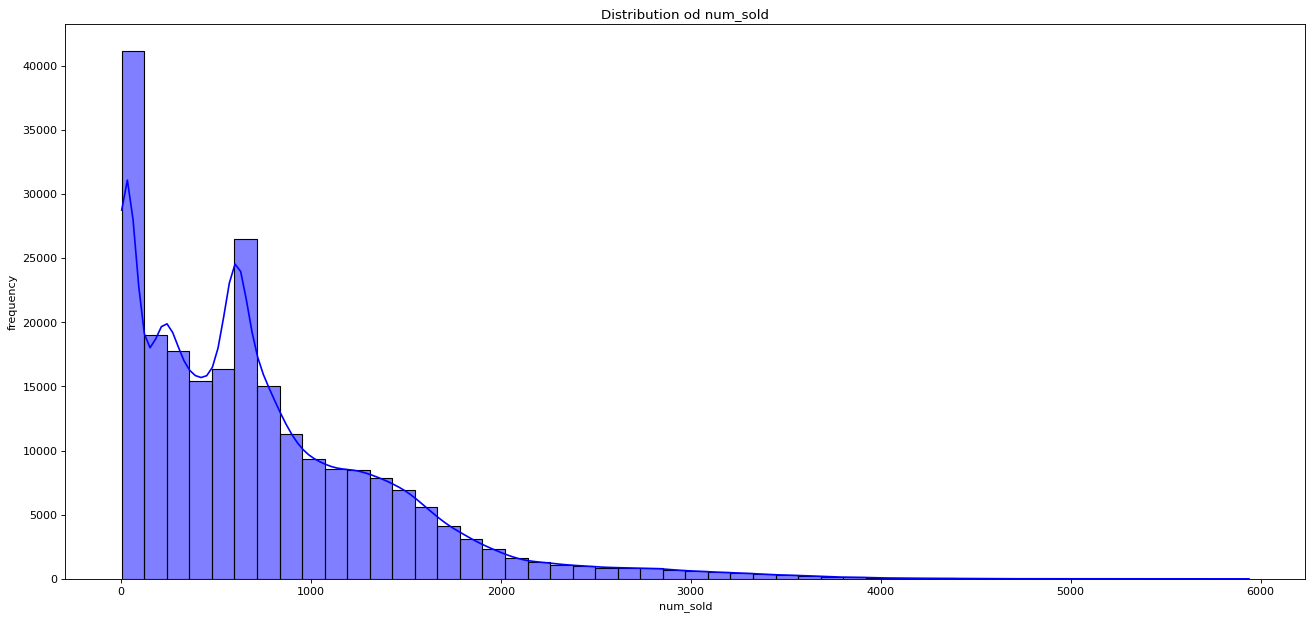

In [53]:
plt.figure(figsize=(20,9), dpi=80)
sns.histplot(df_train['num_sold'],kde=True, bins=50, color='blue')
plt.title('Distribution od num_sold')
plt.xlabel('num_sold')
plt.ylabel('frequency')
plt.show()

In [54]:
def Forecasting_num_sold(df, share_type='num_sold', samples=500,period=24):

    # Decompose the time series using the seasonal_decompose method.
    if samples == 'all':
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    fig, axs=plt.subplots(4, figsize=(20,18))
    
    axs[0].set_title('observed')
    axs[0].plot(observed)
    axs[0].grid()
    
    axs[1].set_title('trend')
    axs[1].plot(trend)
    axs[1].grid()
    
    axs[2].set_title('seasonal')
    axs[2].plot(seasonal)
    axs[2].grid()
    
    axs[3].set_title('residual')
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

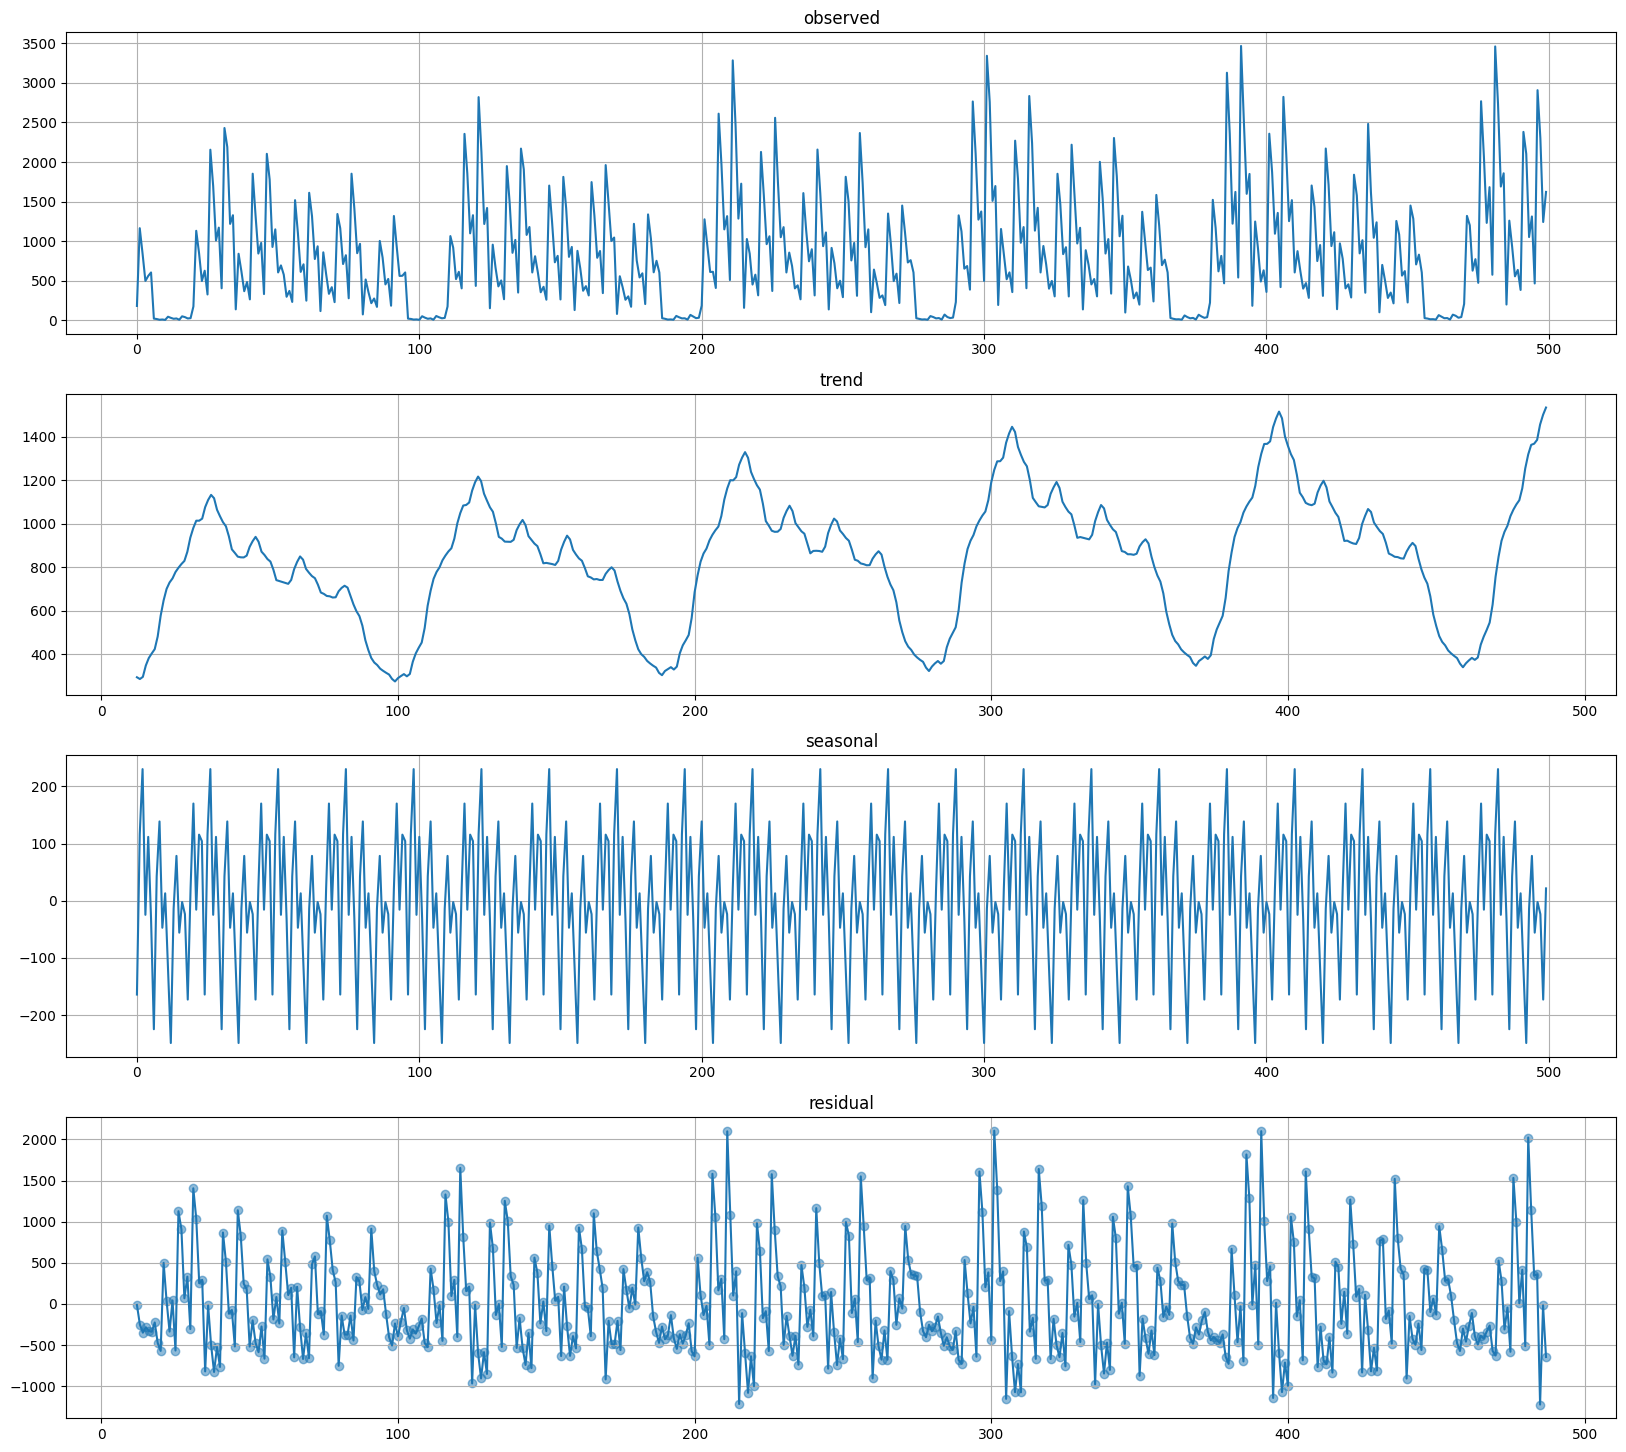

In [55]:
Forecasting_num_sold(df_train, share_type='num_sold', samples=500, period=24)

In [56]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df_train['num_sold'])

ADF Test Statistic : -32.506617942859116
p-value : 0.0
#Lags Used : 84
Number of Observations : 230045
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


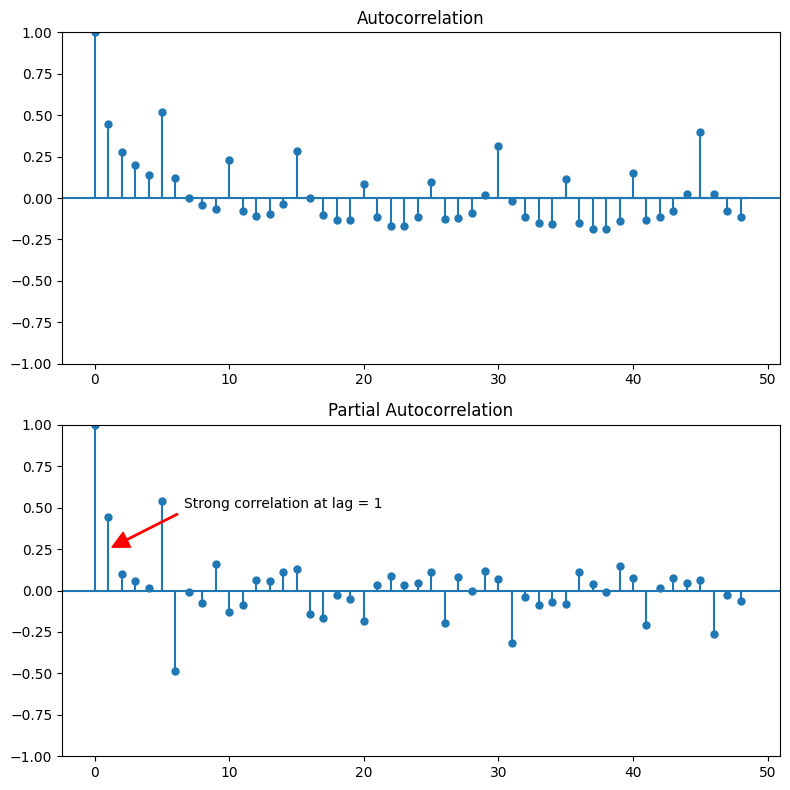

In [57]:
lag_acf = 48
lag_pacf = 48
height = 4
width = 8

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(df_train['num_sold'],lags=lag_acf, ax=ax[0])
plot_pacf(df_train['num_sold'],lags=lag_pacf, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.25),  xycoords='data',
            xytext=(0.17, 0.75), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

In [58]:
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

In [59]:
df_train.head(5)

,date,country,store,product,num_sold
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,605.0
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


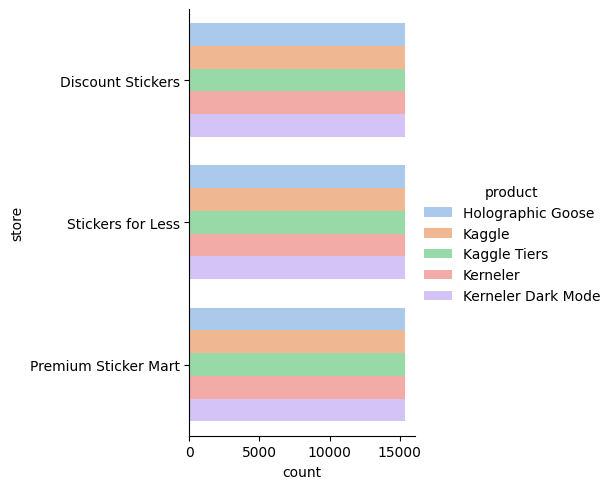

In [60]:
sns.catplot(
    data = df_train, y="store", hue="product", kind='count', palette="pastel" 
)

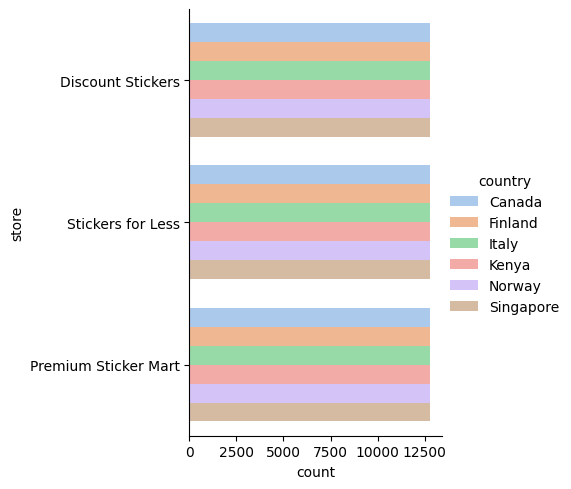

In [61]:
sns.catplot(
    data=df_train, y="store", hue="country", kind="count",
    palette="pastel"
)

In [62]:
# Feature engineering of dates
def extract_date_features(df):
    
    df['date'] = pd.to_datetime(df['date'])    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday 
    df['week'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_week'] = df['date'].dt.dayofweek     
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)    
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)    
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)    
    df['is_year_start'] = df['date'].dt.is_year_start.astype(int)
    df['is_year_end'] = df['date'].dt.is_year_end.astype(int)    
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
    df['Group'] = (df['year'] - 2010) * 48 + df['month'] * 4 + df['day'] // 7
    
    return df

In [63]:
df_train = extract_date_features(df_train)
df_test = extract_date_features(df_test)

In [64]:
df_train.head(5)

,date,country,store,product,num_sold,year,month,day,weekday,week,...,is_year_end,month_sin,month_cos,weekday_sin,weekday_cos,day_of_year_sin,day_of_year_cos,week_sin,week_cos,Group
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,605.0,2010,1,1,4,53,...,0,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709,4
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,4,53,...,0,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709,4
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,4,53,...,0,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709,4
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,4,53,...,0,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709,4
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,4,53,...,0,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709,4


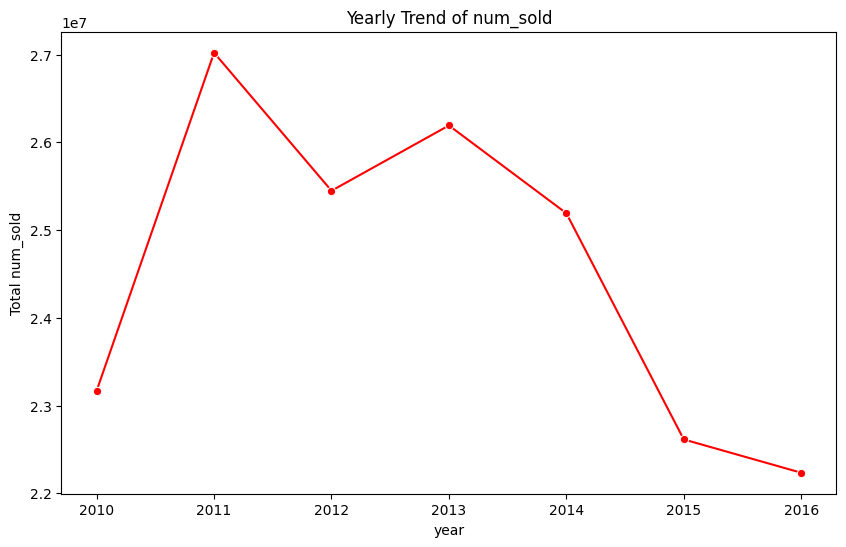

In [65]:
year_sales = df_train.groupby('year')['num_sold'].sum().reset_index()

plt.figure(figsize=(10,6), dpi=100)
sns.lineplot(data=year_sales, x='year', y='num_sold', marker='o', color='red')
plt.title('Yearly Trend of num_sold')
plt.ylabel('Total num_sold')
plt.show()

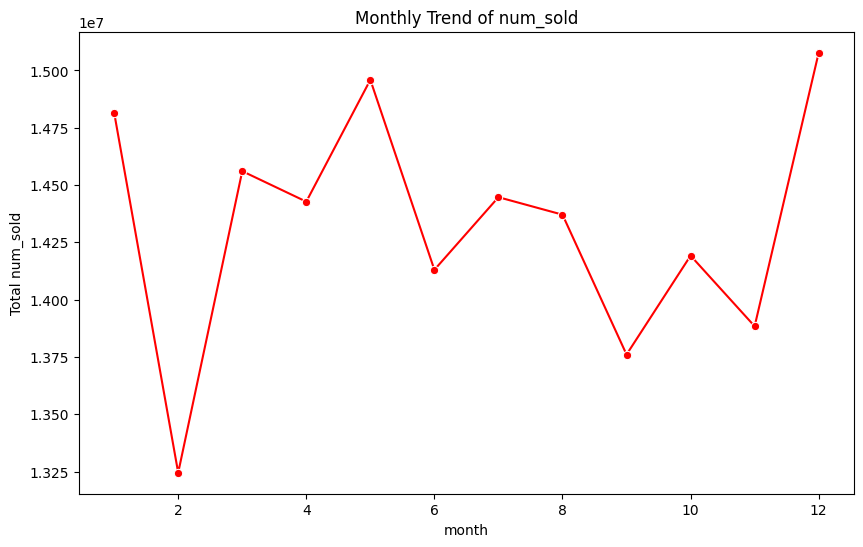

In [66]:
month_sales = df_train.groupby('month')['num_sold'].sum().reset_index()

plt.figure(figsize=(10,6), dpi=100)
sns.lineplot(data=month_sales, x='month', y='num_sold', marker='o', color='red')
plt.title('Monthly Trend of num_sold')
plt.ylabel('Total num_sold')
plt.show()

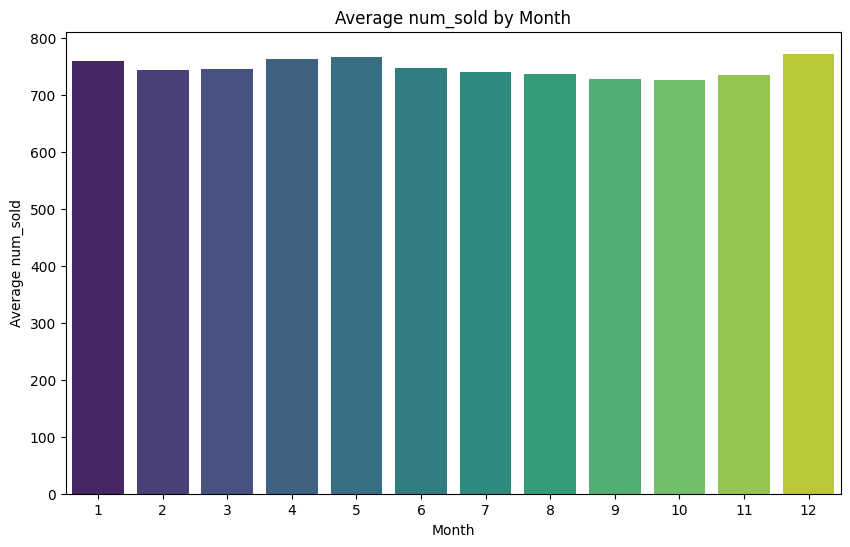

In [67]:
monthly_sales = df_train.groupby('month')['num_sold'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_sales, x='month', y='num_sold', palette='viridis')
plt.title('Average num_sold by Month')
plt.xlabel('Month')
plt.ylabel('Average num_sold')
plt.show()

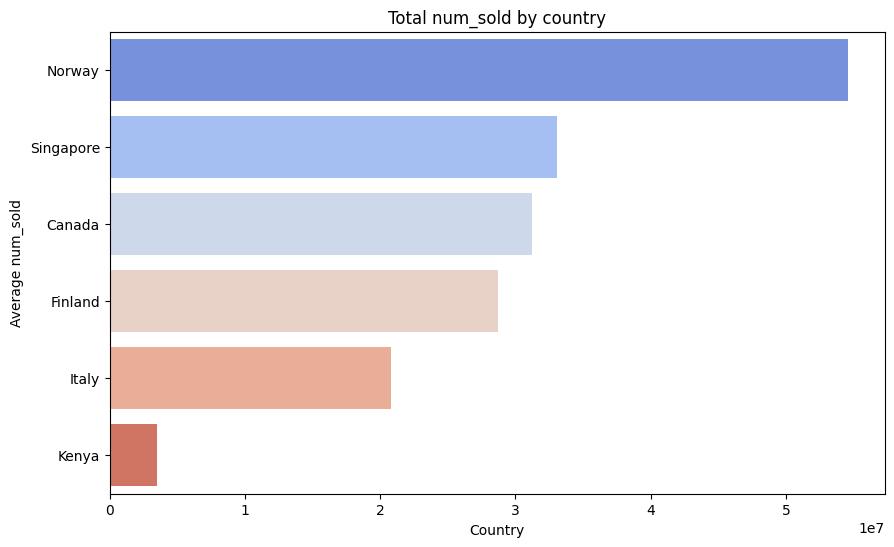

In [68]:
country_sales = df_train.groupby('country')['num_sold'].sum().reset_index().sort_values(by='num_sold', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=country_sales, x='num_sold', y='country', palette='coolwarm')
plt.title('Total num_sold by country')
plt.xlabel('Country')
plt.ylabel('Average num_sold')
plt.show()

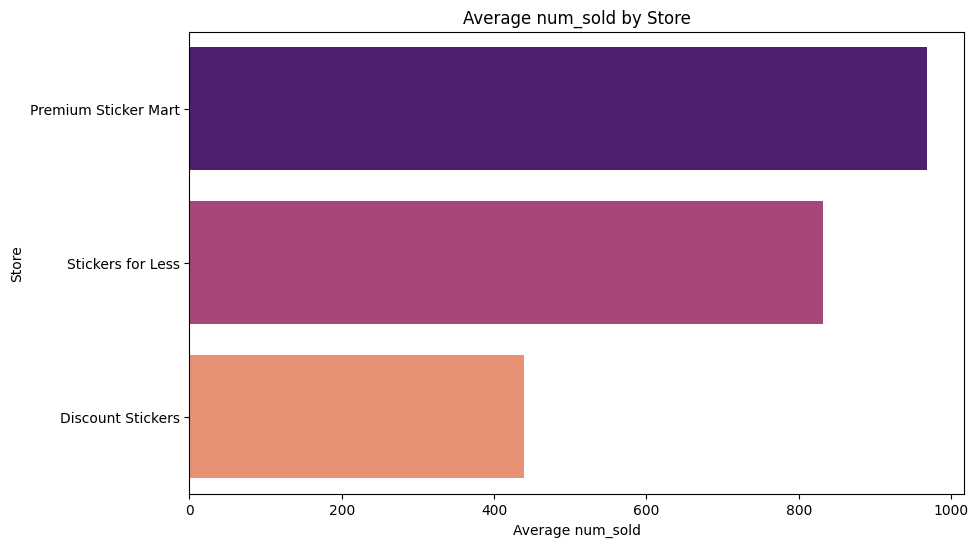

In [69]:
store_sales = df_train.groupby('store')['num_sold'].mean().reset_index().sort_values(by='num_sold', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=store_sales, x='num_sold', y='store', palette='magma')
plt.title('Average num_sold by Store')
plt.xlabel('Average num_sold')
plt.ylabel('Store')
plt.show()

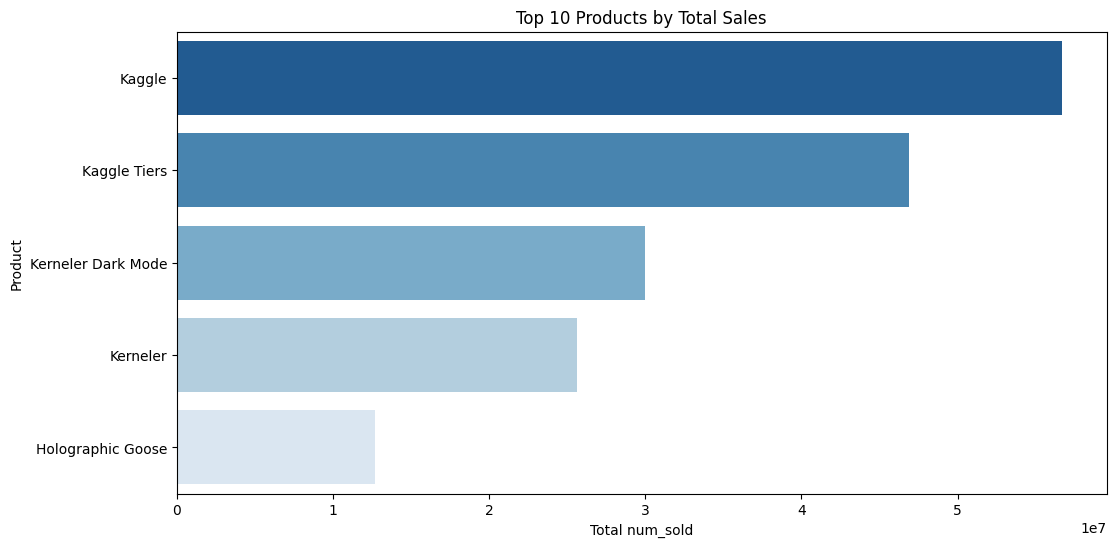

In [70]:
product_sales = df_train.groupby('product')['num_sold'].sum().reset_index().sort_values(by='num_sold', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=product_sales, x='num_sold', y='product', palette='Blues_r')
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Total num_sold')
plt.ylabel('Product')
plt.show()

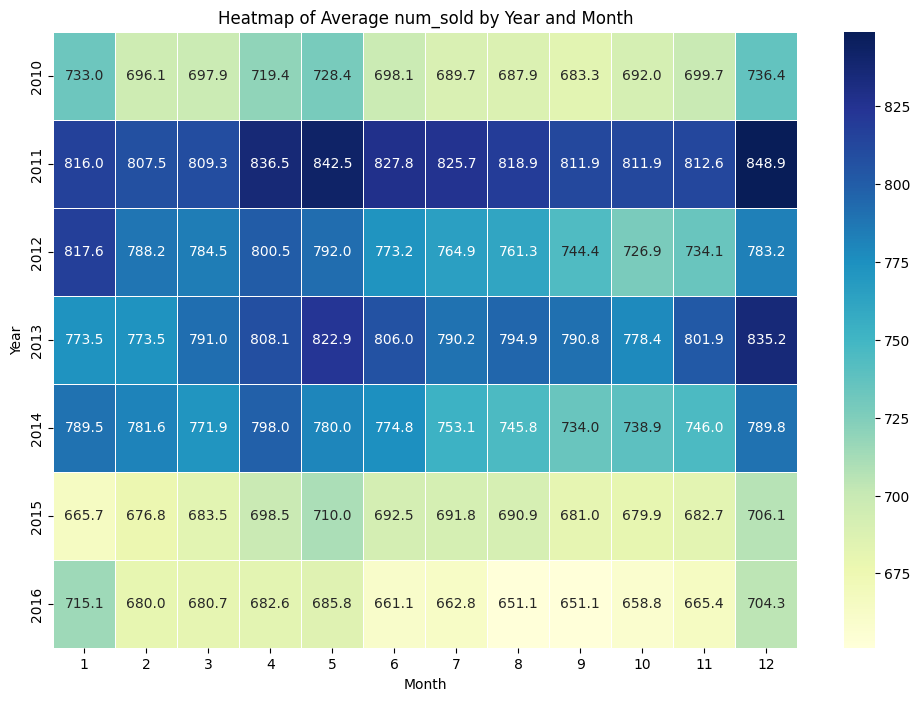

In [71]:
heatmap_data = df_train.groupby(['year', 'month'])['num_sold'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5)
plt.title('Heatmap of Average num_sold by Year and Month')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

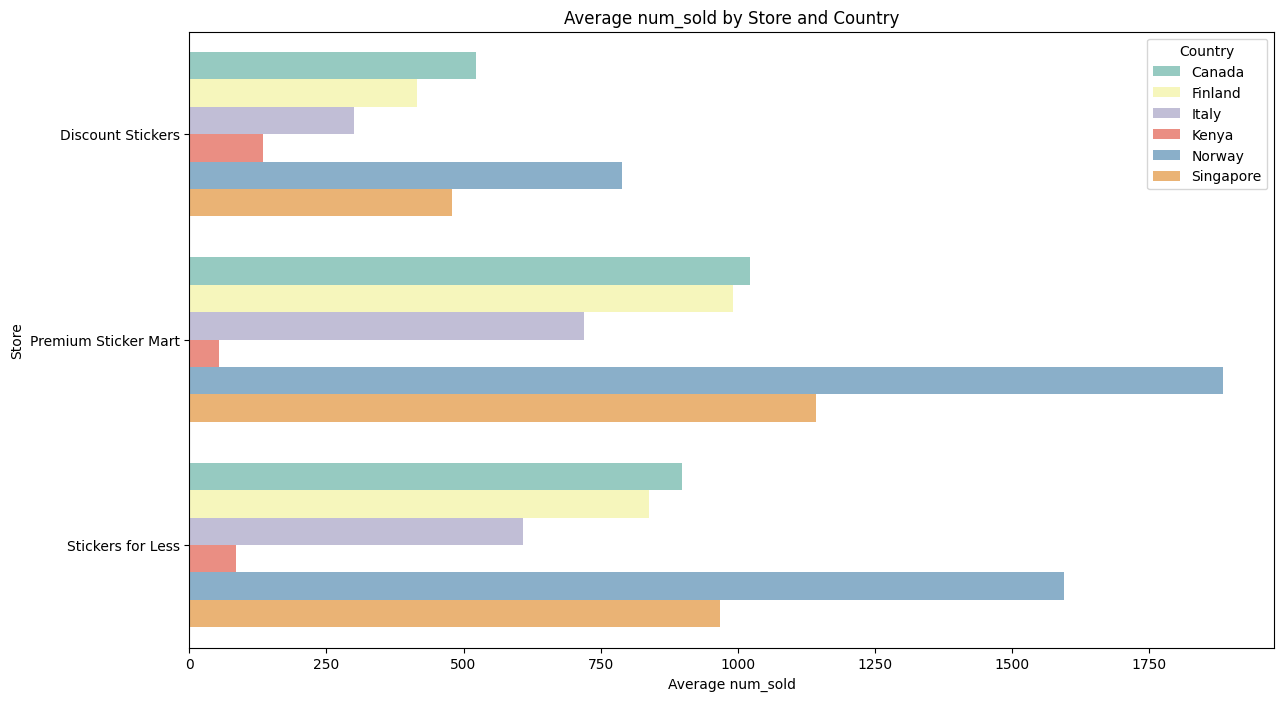

In [72]:
country_store_sales = df_train.groupby(['country', 'store'])['num_sold'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(data=country_store_sales, x='num_sold', y='store', hue='country', palette='Set3')
plt.title('Average num_sold by Store and Country')
plt.xlabel('Average num_sold')
plt.ylabel('Store')
plt.legend(title='Country')
plt.show()

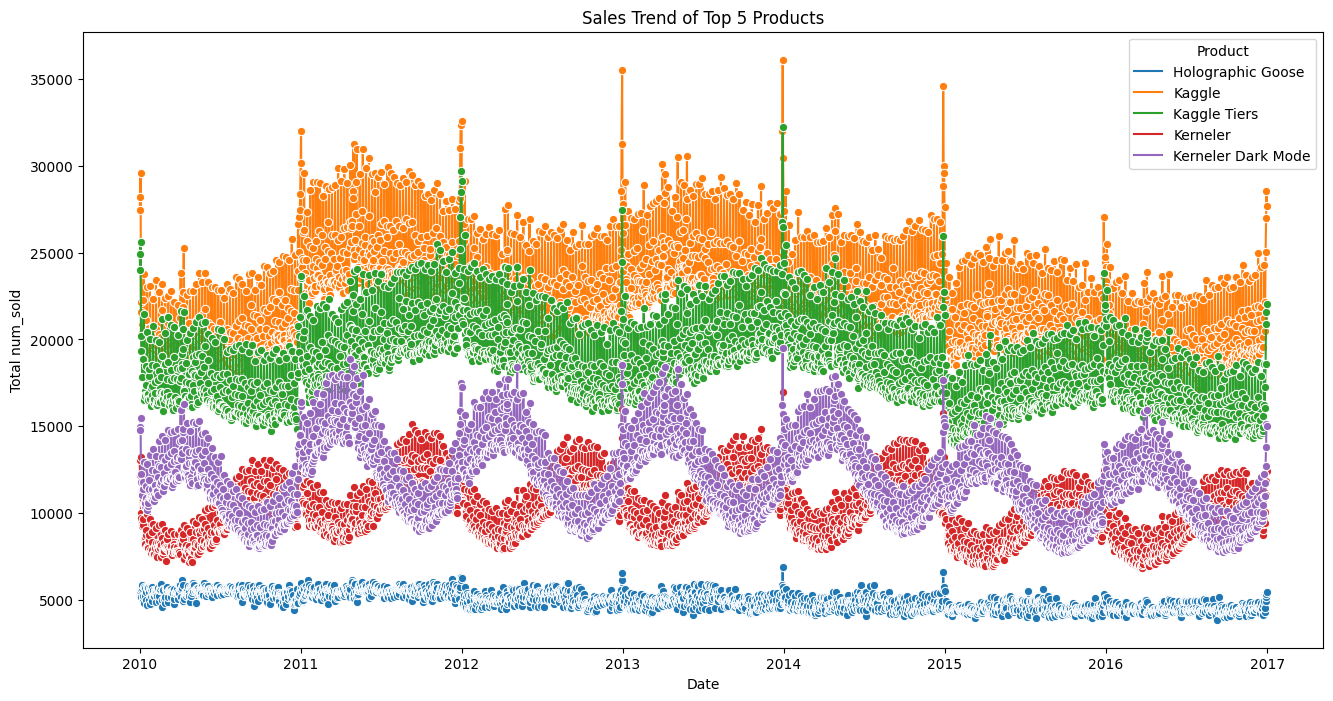

In [73]:
top_products = df_train.groupby('product')['num_sold'].sum().nlargest(5).index
top_product_sales = df_train[df_train['product'].isin(top_products)].groupby(['date', 'product'])['num_sold'].sum().reset_index()

plt.figure(figsize=(16, 8))
sns.lineplot(data=top_product_sales, x='date', y='num_sold', hue='product', marker='o')
plt.title('Sales Trend of Top 5 Products')
plt.xlabel('Date')
plt.ylabel('Total num_sold')
plt.legend(title='Product')
plt.show()

In [74]:
df_train.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

In [75]:
# Conversion of categorical variables to statistical features based on target variables

def target_enconding(df_train, df_test, target_column, categorical_columns):
    encoding_map={}

    for col in categorical_columns:
        target_mean = df_train.groupby(col)[target_column].mean()
        encoding_map[col] = target_mean
        df_train[f'{col}_encoded'] = df_train[col].map(target_mean)
        df_train[f'{col}_encoded'].fillna(df_train[target_column].mean(), inplace=True)
    
    for col in categorical_columns:
        df_test[f'{col}_encoded'] = df_test[col].map(encoding_map[col])
        df_test[f'{col}_encoded'].fillna(df_train[target_column].mean(), inplace=True)

    return df_train, df_test

categorical_columns=['country', 'store', 'product']
df_train, df_test = target_enconding(df_train, df_test, target_column='num_sold', categorical_columns=categorical_columns)

print("Training DataFrame with Encoded Columns:")
print(df_train.head(5))
print("\nTest DataFrame with Encoded Columns:")
print(df_test.head(5))        

Training DataFrame with Encoded Columns:
  country              store             product  num_sold  year  month  day  \
0  Canada  Discount Stickers   Holographic Goose     605.0  2010      1    1   
1  Canada  Discount Stickers              Kaggle     973.0  2010      1    1   
2  Canada  Discount Stickers        Kaggle Tiers     906.0  2010      1    1   
3  Canada  Discount Stickers            Kerneler     423.0  2010      1    1   
4  Canada  Discount Stickers  Kerneler Dark Mode     491.0  2010      1    1   

   weekday  week  quarter  ...  weekday_sin  weekday_cos  day_of_year_sin  \
0        4    53        1  ...    -0.433884    -0.900969         0.017213   
1        4    53        1  ...    -0.433884    -0.900969         0.017213   
2        4    53        1  ...    -0.433884    -0.900969         0.017213   
3        4    53        1  ...    -0.433884    -0.900969         0.017213   
4        4    53        1  ...    -0.433884    -0.900969         0.017213   

   day_of_year_

In [76]:
# one-hot encoding
X = pd.get_dummies(df_train, columns=['country', 'store', 'product'], dtype=int, drop_first=True)
X = X.drop(columns=['num_sold'])
y = np.log1p(df_train['num_sold'])

In [77]:
X_test = df_test

In [78]:
X_test = pd.get_dummies(df_test, drop_first=True, dtype=int)

In [79]:
scaled_train_data = X
scaled_test_data = X_test

In [80]:
lgb_params={
                'num_leaves': 426,
                 'max_depth': 20,
                 'learning_rate': 0.011353178352988012,
                 'n_estimators': 1000,
                 'metric': 'rmse',
                 'subsample': 0.5772552201954328,
                 'colsample_bytree': 0.9164865430101521,
                 'reg_alpha': 1.48699088003429e-06,
                 'reg_lambda': 0.41539458543414265,
                 'min_data_in_leaf': 73,
                 'feature_fraction': 0.751673655170548,
                 'bagging_fraction': 0.5120415391590843,
                 'bagging_freq': 2,
                 'random_state': 42,
                 'min_child_weight': 0.017236362383443497,
                 'cat_smooth': 54.81317407769262,
                 'verbose' : -1,
                 'early_stopping_rounds': 200,
}

In [81]:
lgbm_predictions = np.zeros(len(scaled_train_data))
lgbm_true_labels = np.zeros(len(scaled_train_data))
lgbm_test_predictions = np.zeros(len(scaled_test_data))

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")   
    X_train, X_val = scaled_train_data.iloc[train_idx], scaled_train_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    lgbm_model = LGBMRegressor(**lgb_params)
    lgbm_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')
    lgbm_fold_preds = lgbm_model.predict(X_val)
    lgbm_fold_test_preds = lgbm_model.predict(scaled_test_data)
    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val 
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits
    fold_mape = mean_absolute_percentage_error(y_val, lgbm_fold_preds)
    print(f"Fold {fold + 1} MAPE: {fold_mape:.4f}")
overall_mape_lgbm = mean_absolute_percentage_error(lgbm_true_labels, lgbm_predictions)
print(f"Overall MAPE (LGBMRegressor): {overall_mape_lgbm:.4f}")

Training fold 1/5...
Fold 1 MAPE: 0.0148
Training fold 2/5...
Fold 2 MAPE: 0.0150
Training fold 3/5...
Fold 3 MAPE: 0.0154
Training fold 4/5...
Fold 4 MAPE: 0.0156
Training fold 5/5...
Fold 5 MAPE: 0.0151
Overall MAPE (LGBMRegressor): 0.0152


In [83]:
df_sub = pd.read_csv('/kaggle/input/playground-series-s5e1/sample_submission.csv')
df_sub['num_sold'] = lgbm_test_predictions
df_sub.to_csv("submission.csv", index=False)
print("submission saved!")

submission saved!
